# Intuit Quickbooks Upgrade

* Team-lead GitLab userid: juespino
* Group name: Team17
* Team member names: Julian Espinoza Martinez, Praveen Kumar Basker, Haritha Parupudi & William Quinn

## Setup

Please complete this python notebook with your group by answering the questions in `intuit.pdf`. Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML file from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the first group assignment for MGTA 455 and you will be using Git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's change to accept so the team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. You can seen an example of this in action below for the `question1.ipynb` notebook

Some group work-flow tips:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file 
* If you are going to work simultaneously, do it in different notebooks, e.g., 
    - question1.ipynb, question2.ipynb, question3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook
* Put python functions in modules that you can import from your notebooks. See the example below for the `example` function defined in `utils/functions.py`

A graphical depiction of the group work-flow is shown below:

![](images/git-group-workflow-wbg.png)

Tutorial videos about using Git, GitLab, and GitGadget for group assignments:

* Setup the MSBA server to use Git and GitLab: https://youtu.be/zJHwodmjatY
* Dealing with Merge Conflicts: https://youtu.be/qFnyb8_rgTI
* Group assignment practice: https://youtu.be/4Ty_94gIWeA

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sms
from sklearn import metrics
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split


# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
#intuit75k.head()

In [3]:
###### show dataset description
rsm.describe(intuit75k)

## Intuit: Quickbooks upgrade

The purpose of this exercise is to gain experience modeling the response to an upsell campaign. The `intuit75k.rds` file contains data on 75,000 (small) businesses that were selected randomly from the 801,821 that were sent the wave-1 mailing. The mailing contained an offer to upgrade to the latest version of the Quickbooks software. 

Variable `res1` denotes which of these businesses responded to the mailing by purchasing Quickbooks version 3.0 from Intuit Direct. Note that Intuit Direct sells products directly to its customers rather than through a retailer. Use the available data to predict which businesses that did not respond to the wave-1 mailing, are most likely to respond to the wave-2 mailing. Note that variables were added, deleted, and recoded so please ignore the variable descriptions in Exhibit 3 in the case in the course reader. Instead, use the variable descriptions below:

## Variable description

* id: Small business customer ID
* zip: 5-

In [4]:
# importing functions from a module/package
from utils import functions

#functions.example()

## BACKGROUND

To model the response to an upsell campaign by Intuit for its QuickBooks software, a dataset of 75,000 small businesses will be used from the 801,821 originally mailed businesses from the Wave-1 campaign. From this dataset, we know the businesses that responded favorably by purchasing QuickBooks version 3.0 from Intuit Direct, in the form of the `res1` variable. 

Using this data, as loaded above as `intuit75k`, we will predict the businesses, that did not respond to Wave-1 mailing, will most likely respond to the Wave-2 campaign.

### **I) Approach**

The main approach taken to determine which business should be targeted for the wave-2 mailing campaign will be as follows:

1) Build an **RFM Models** (using identical and sequential quintiles to build bins)   
2) Build **Logistic Regression Models**   
3) Build a **Neural Network**   

Between the predictive models built within each type of model above, we will compare the performances and calculate the predictive profits for Wave 1 using the model. Then, using the performance metrics and the calculated profits, a final predictive model will be chosen. And this model will be used for the final scaled up predicted profit calculation of the $801,821$ businesses.

A breakeven value of $\frac{1.41}{60} = 0.0235$ will be used for all the models.

### **II) RFM Model**

The detailed calculations and notes can be seen in the Appendix below. 

* This model was developed using both independent and sequential quintiles and the variables `last` for recency, `numords` for frequency and `dollars` for monetary bins. These three were then combined for the RFM bins for both independent(IQ) and sequential(SQ) quintiles.

* The profits for RFM(IQ) was \\$35,090 with a return on investment(ROME) of 127.37%.    
The profits for RFM(SQ) based targeting was $34,735 with a comparable ROME of 127.5%.   
Simply looking at the profit margin for these two methods, RFM(IQ) targeting results in a better profit, but it would make more sense to use the sequential approach using the slightly higher ROME values. If these were the highest Wave-1 profits, we would have further explored this, but this was not the case.

* For the RFM Model, the only metrics were the profit and ROME to evaluate the model.

* The construction of the RFM bins (as explained above) was the only new variables created for this model. To do so, the `xtile` function in the `pyrsm` function was utilized.

### **III) Logistic Regression Model**

The detailed calculations and notes can be seen in the Appendix below. 

* For this, 5 predictive models were developed in total (1 base model + 4 other models). The models are summarized as follows, with the variables used to build each model.

> Base Model: `bizflag + zip_bins + numords + dollars + last + sincepurch + version1 + owntaxprod + upgraded`   
> Model 2: `zip_bins + numords + dollars + last + version1 + owntaxprod + upgraded`   
> Model 3: `z_81 + z_84 + numords + dollars + last + version1 + owntaxprod + upgraded`   
> Model 4: `zip_bins + bizflag + numords + dollars + last + upgraded + owntaxprod + bizflag:version1`   
> Model 5: `new_bins + numords + dollars + last + version1 + owntaxprod:upgraded` 

* To compare and evaluate the models, we first evaluated how good the model's variables were by looking at the significance (for a $95$% confidence interval, where $p < 0.005$). We continued by ensuring no multicollinearity existed between the variables used to build the model, by checking the VIF. We then looked at the pseudo $R^2$ value for the model, which we tried to maximize, but did not give the most weightage to because of the creation of variables. To pick the best regression model, we then used the generated profits of the model on wave 1. These 4 models were the best of nearly 25 models that were tried, with different variables and interactions. 

* To ensure these models were not overfit to the training data, we created gains and lift plots to check as well.

* The results of the models are summarized in the table below.

In [5]:
profits = [38561.49, 38557.26, 38528.16, 38491.62, 38782.65]
prof_ind = ['base_profit', 'nobizpurch_profit (M2)', 'addzip_profit (M3)', 'v1biz_profit (M4)', 'newbin_profit (M5)']

profits = pd.DataFrame(profits, index = prof_ind)
profits.columns = ['Profits (USD)']
profits = profits.sort_values('Profits (USD)', ascending = False)
profits

,Profits (USD)
newbin_profit (M5),38782.65
base_profit,38561.49
nobizpurch_profit (M2),38557.26
addzip_profit (M3),38528.16
v1biz_profit (M4),38491.62


* The new variables created that were tested here were based on the zipcode variables. 

> `z_81`, `z_84`, `international`, and `others` were created for the two zipcodes which had the highest `dollar` sums (00801 and 00804) and the international (99999) zipcpdes. The `other` simply refers to businesses that did not fall into any of these categories. But when tested in Model 3 above, there was not a noticeable difference in performance (as seen in the $R^2$ value, nor in the overall profit. These variables were also used in interactions, but a positive change was not observed due to these variables.

> `new_bins` was created to consolidate the zip_bins further to deciles. We believed that this would help observe the effectiveness of the locations, and since zipcodes are based on regions, the effect of location would be better seen here.  

* Looking at the table above, the most profitable model for the logistic regression model is the one with the creation of the new bins based on the zip bins. 

* Here we'll discuss the base model and the most profitable model:

> Base Model: The pseudo $R^2$ was fairly high with a value of 0.114 and the VIF was in range, with values less than 2 across the board for all the variables. When looking at the significance of the variables, 2 variables (`bizflag` and `sincepurch`) had p-values > 0.005. Thus, in the subsequent models models, we attempred to address this by ommitting the variables to check the performance, which only slightly changed the performance and overall profit. The detailed numbers are available in the attached Appnedix. The gains plot for this model does not indicate overfitting on the training dataset either. And the overall calculated profit was \\$38,561.49. When looking at all the variables, since the 2 aforementioned variables had p-values exceeding 0.005, we checked the effect of removing them in the next model, but since the effect was negligible, the best model when looking at all the original variables is the base model.

> New Bins Model: The pseudo $R^2$ for this model, with an added variable and interaction, was slightly lower, with a value of 0.094. But with the added interaction between `owntaxprod` and `upgraded`, we were able to test another effect. After checking the effects of the the given variables, we decided to further cut down the bins of the zipcodes by using the existing `zip_bins`.

### **IV) Neural Networks (NN)**

The detailed calculations and notes can be seen in the Appendix below. 

* This model was constructed by changing the variables (as listed below) to dummy variables first. The neural network was then built using an activation of `relu` and solver of `adam` because the data being used is larger, in the thousands.  

* To determine the performance of this model, a combination of GridSearchCV, to optimize the parameters, and the ROC-curve, with the AUC score were used. Since a neural network regresses upon itself, the best model suggested by GridSearchCV resulted in a higher score. But for a problem with such few variables, adding additional hidden layers has the risk of leading to an over-fit model. Thus, the hidden layers were capped at 2 for our model. 

* The optimal model had 1 hidden layer and an AUC of approximately 0.76. While the difference in profit for this model and the logistic regression model was not very significant (<$1,500), there are other implications which render logistic regression a better suited model.

* The cumulative lifts and gains, as seen in the Appendix, are higher for the logistic regression model than the neural network. In addition to the sensitivity of using a random state within the model, the OS affects the results of the neural net. Because of this over-sensitivity to factors that cannot necessarily be controlled, we have opted to use the logistic regression model. And we will be using the most profitable model, with respect to wave 1 results. 

* The new variables here were the same ones used above in the logistic regression model.

### **V) Profits**

To calculate the profit on the test set, using the generated profit on the test set, we use the following formula: 

$\frac{profit}{(22500 - 1103)} * (801821 - 38487)$

And we get a final profit of \\$1,057,238.88 for the entire dataset.

### **VI) Key Takeaways**

Exploring the dataset and looking at the businesses which we will be targeting with our models, these are some of the main takeaways about the businesses that our model targets, and thus we believe are likely to upgrade:

* The top 3 targeted business belong to zipcodes `00801`, `99999` and `00804`
* More businesses that only purchased once in the last 36 months were targeted
* We tend to target businesses that have actually not purchased Intuit Tax Products previously, since these businesses likely responded to wave 1 already because of their loyalty to the company
* Businesses that are still operating on version 1 of the software or have not upgraded are more likely to be targeted
* Businesses that have recently purchased (with the time since their last purchase being 1-2 months) are targeted more than customers whose last purchase with the company was 36 months ago

# APPENDIX

## RFM Model

We begin by building an RFM model with independent and sequential bins. 

In [6]:
# RFM indexing on the full data set
# creating the independent quintile variables
intuit75k = intuit75k.assign(rec_iq=rsm.xtile(intuit75k["last"], 5, rev=False))
intuit75k = intuit75k.assign(freq_iq=rsm.xtile(intuit75k["numords"], 5, rev=True))
intuit75k = intuit75k.assign(mon_iq=rsm.xtile(intuit75k["dollars"], 5, rev=True))

# creating independent RFM bins
intuit75k = intuit75k.assign(
    rfm_iq=intuit75k["rec_iq"].astype(str)
    + intuit75k["freq_iq"].astype(str)
    + intuit75k["mon_iq"].astype(str)
)

# creating the sequential quintile variables
intuit75k = intuit75k.assign(
    freq_sq=intuit75k.groupby("rec_iq")["numords"].transform(rsm.xtile, 5, rev=True)
)
intuit75k = intuit75k.assign(
    mon_sq=intuit75k.groupby(["rec_iq", "freq_sq"])["dollars"].transform(
        rsm.xtile, 5, rev=True
    )
)

# creating sequential RFM bins
intuit75k = intuit75k.assign(
    rfm_sq=intuit75k["rec_iq"].astype(str)
    + intuit75k["freq_sq"].astype(str)
    + intuit75k["mon_sq"].astype(str)
)

In [7]:
# breakeven calculation
breakeven = 1.41 / 60

# profit calculation using no targeting on Wave 1
no_target_prof = 75000 * (
    (intuit75k[intuit75k["res1"] == "Yes"].shape[0] / 75000) * 60 - 1.41
)
no_target_rome = no_target_prof / (75000 * 1.41)

print(
    f"""The Profit is ${int(no_target_prof):,} and the the return on investment is {round(float(no_target_rome)*100,2):,}% without any targeting efforts from Wave 1 mailing."""
)

The Profit is $110,309 and the the return on investment is 104.31% without any targeting efforts from Wave 1 mailing.


In [8]:
# profit on test dataset with targetting- based on RFM_iq and RFM_sq for Wave 1 campainging
# mailto function to determine who to mail
def mailto(y, lev="Yes", breakeven=0):
    return np.nanmean(y == "Yes") > breakeven


# determine who to target using independent and sequential RFM bins
intuit75k = intuit75k.assign(
    target_iq=intuit75k.groupby("rfm_iq")["res1"].transform(mailto, breakeven=breakeven)
)
intuit75k = intuit75k.assign(
    target_sq=intuit75k.groupby("rfm_sq")["res1"].transform(mailto, breakeven=breakeven)
)
rr = intuit75k[intuit75k["res1"] == "Yes"].shape[0] / 75000


def perf_calc_se(x):
    if x == "sq":
        a = "target_sq"
    elif x == "iq":
        a = "target_iq"
    else:
        a = 0
    df = intuit75k[intuit75k[a] == True]
    df = df[df['training'] == 0]
    nr_mail = df.shape[0]
    nr_resp = df[df["res1"] == "Yes"].shape[0]
    mail_cost = 1.41 * nr_mail
    revenue = 60 * nr_resp
    profit = revenue - mail_cost
    ROME = profit / mail_cost
    return profit, ROME


profit_sq_se, ROME_sq_se = perf_calc_se("sq")
profit_iq_se, ROME_iq_se = perf_calc_se("iq")
print(
    f"""Targeting based on Independent quintiles RFM bins: The Profit is ${int(profit_iq_se):,} and the the return on investment is {round(float(ROME_iq_se)*100,2):,}% ."""
)
print(
    f"""Targeting based on Sequential quintiles RFM bins: The Profit is ${int(profit_sq_se):,} and the the return on investment is {round(float(ROME_sq_se)*100,2):,}% ."""
)

Targeting based on Independent quintiles RFM bins: The Profit is $35,090 and the the return on investment is 127.37% .
Targeting based on Sequential quintiles RFM bins: The Profit is $34,735 and the the return on investment is 127.5% .


## Logistic Regression Model

Next, we will look at logistic modeling to determine the maximum profit of Wave 1 campaining. Below, the variables used to build the 5 models will be outlined.

> Base Model: `bizflag + zip_bins + numords + dollars + last + sincepurch + version1 + owntaxprod + upgraded`   
> Model 2: `zip_bins + numords + dollars + last + version1 + owntaxprod + upgraded`   
> Model 3: `z_81 + z_84 + numords + dollars + last + version1 + owntaxprod + upgraded`   
> Model 4: `zip_bins + bizflag + numords + dollars + last + upgraded + owntaxprod + bizflag:version1`   
> Model 5: `new_bins + numords + dollars + last + version1 + owntaxprod:upgraded`   

#### Base Regression Model

In [9]:
# new variable creation
intuit75k["z_81"] = (intuit75k["zip"] == "00801").astype(int)
intuit75k["z_84"] = (intuit75k["zip"] == "00804").astype(int)
intuit75k["international"] = (intuit75k["zip"] == "99999").astype(int)
interest = ["00801", "00804", "99999"]
intuit75k["others"] = (~intuit75k["zip"].isin(interest)).astype(int)
intuit75k["new_bins"] = rsm.xtile(intuit75k["zip_bins"], 10, rev=False)

In [10]:
# converting types of variables and creation of necessary dummy variables
intuit75k["zip_bins"] = intuit75k["zip_bins"].astype("category")
intuit75k["version1"] = intuit75k["version1"].astype("category")
intuit75k["owntaxprod"] = intuit75k["owntaxprod"].astype("category")
intuit75k["upgraded"] = intuit75k["upgraded"].astype("category")
intuit75k["bizflag"] = intuit75k["bizflag"].astype("category")
intuit75k["international"] = intuit75k["international"].astype("category")
intuit75k["z_81"] = intuit75k["z_81"].astype("category")
intuit75k["z_84"] = intuit75k["z_84"].astype("category")
intuit75k["others"] = intuit75k["others"].astype("category")
intuit75k["new_bins"] = intuit75k["new_bins"].astype("category")

In [11]:
# standardization before starting regression
# variables to standardize
is_num = ["numords", "dollars", "last", "sincepurch"]

# standardization
X_colnames = intuit75k.loc[[0], "numords":"sincepurch"].columns
scaler = preprocessing.StandardScaler()
sf = scaler.fit(intuit75k.query("training == 1")[X_colnames])
sf.scale_ = sf.scale_ * 2
int_std = intuit75k.copy()

# new standardized cols
int_std[is_num] = sf.transform(intuit75k[X_colnames])

In [12]:
# base regression model, with the omission of id, sex, zip, res1 and training, with a response variable of res1_yes
lr_base = smf.glm(
    formula="res1_yes ~ bizflag + zip_bins + numords + dollars + last + sincepurch + version1 + owntaxprod + upgraded",
    family=Binomial(link=logit()),
    data=int_std.query("training == 1"),
)
lr_base_mod = lr_base.fit()

In [13]:
# function to display the statistics for the regression model
def logit_disp(model, fit):
    rsm.model_fit(fit)
    display(fit.summary())
    display(rsm.vif(model))

In [14]:
logit_disp(lr_base, lr_base_mod)


Pseudo R-squared (McFadden): 0.114
Pseudo R-squared (McFadden adjusted): 0.111
Log-likelihood: -8900.095, AIC: 17856.191, BIC: 18104.511
Chi-squared: 51309.082 df(27), p.value < 0.001 
Nr obs: 52,500



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               res1_yes   No. Observations:                52500
Model:                            GLM   Df Residuals:                    52472
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8900.1
Date:                Thu, 11 Feb 2021   Deviance:                       17800.
Time:                        10:32:23   Pearson chi2:                 5.13e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.8193      0.064    -28.565      0.000      -1.944      -1.694
bizflag[T.1]        0.0356      0.049      0.725      0.468      -0.061       0.132
zip_bins[T.2]      -1.9099      0.110    -17.296      0.000      -2.126      -1.693
zip_bins[T.3]      -2.1403      0.121    -17.705      0.000      -2.377      -1.903
zip_bins[T.4]      -1.9957      0.112    -17.808      0.000      -2.215      -1.776
zip_bins[T.5]      -2.1513      0.120    -17.891      0.000      -2.387      -1.916
zip_bins[T.6]      -2.0671      0.115    -18.040      0.000      -2.292      -1.843
zip_bins[T.7]      -2.1093      0.117    -17.966      0.000      -2.339      -1.879
zip_bins[T.8]      -2.0340      0.114    -17.841      0.000      -2.258      -1.811
zip_bins[T.9]      -2.0855      0.117    -17.853      0.000      -2.314      -1.857
zip_bins[T.10]     -2.1090      0.118    -17.914      0.000      -2.340      -1.878
zip_bins[T.11]     -2.0522      0.116    -17.639      0.000      -2.280      -1.824
zip_bins[T.12]     -1.7624      0.104    -16.868      0.000      -1.967      -1.558
zip_bins[T.13]     -2.1767      0.121    -17.938      0.000      -2.414      -1.939
zip_bins[T.14]     -2.0306      0.115    -17.719      0.000      -2.255      -1.806
zip_bins[T.15]     -2.1349      0.119    -17.892      0.000      -2.369      -1.901
zip_bins[T.16]     -2.0411      0.114    -17.891      0.000      -2.265      -1.818
zip_bins[T.17]     -2.0373      0.114    -17.845      0.000      -2.261      -1.814
zip_bins[T.18]     -1.6979      0.101    -16.742      0.000      -1.897      -1.499
zip_bins[T.19]     -1.9467      0.111    -17.499      0.000      -2.165      -1.729
zip_bins[T.20]     -2.0834      0.116    -17.971      0.000      -2.311      -1.856
version1[T.1]       0.7480      0.087      8.585      0.000       0.577       0.919
owntaxprod[T.1]     0.3045      0.103      2.960      0.003       0.103       0.506
upgraded[T.1]       0.9616      0.086     11.200      0.000       0.793       1.130
numords             0.5700      0.047     12.044      0.000       0.477       0.663
dollars             0.1771      0.044      4.011      0.000       0.091       0.264
last               -0.8354      0.046    -18.072      0.000      -0.926      -0.745
sincepurch          0.0373      0.080      0.466      0.641      -0.120       0.194
===================================================================================
"""

,variable,vif,Rsq
0,sincepurch,3.737,0.732
1,version1[T.1],2.972,0.664
2,upgraded[T.1],2.919,0.657
3,zip_bins[T.7],1.901,0.474
4,zip_bins[T.18],1.900,0.474
5,zip_bins[T.8],1.899,0.474
6,zip_bins[T.6],1.895,0.472
7,zip_bins[T.16],1.893,0.472
8,zip_bins[T.13],1.888,0.470
9,zip_bins[T.5],1.888,0.470


In [15]:
# function to plot the lifts and gains plots
def plots(var, model, model_name):
    intuit75k[var] = model.predict(int_std)
    # lift and gains plot
    w = 13
    h = 4
    d = 100
    fig = plt.figure(figsize=(w, h), dpi=d)
    fig.suptitle(f"Cumulative Lift and Gains For '{model_name}' Model")

    fig1 = fig.add_subplot(122)
    fig1.set_title("Cumulative Gains")
    fig1 = rsm.gains_plot({"Training": intuit75k.query("training == 1"), "Test": intuit75k.query("training == 0"),},
                                rvar="res1_yes", pred=var, lev=1, qnt=10,)

    fig2 = fig.add_subplot(121)
    fig2.set_title("Cumulative Lift")
    fig2 = rsm.lift_plot({"Training": intuit75k.query("training == 1"), "Test": intuit75k.query("training == 0"),},
                                rvar="res1_yes", pred=var, lev=1, qnt=10,)

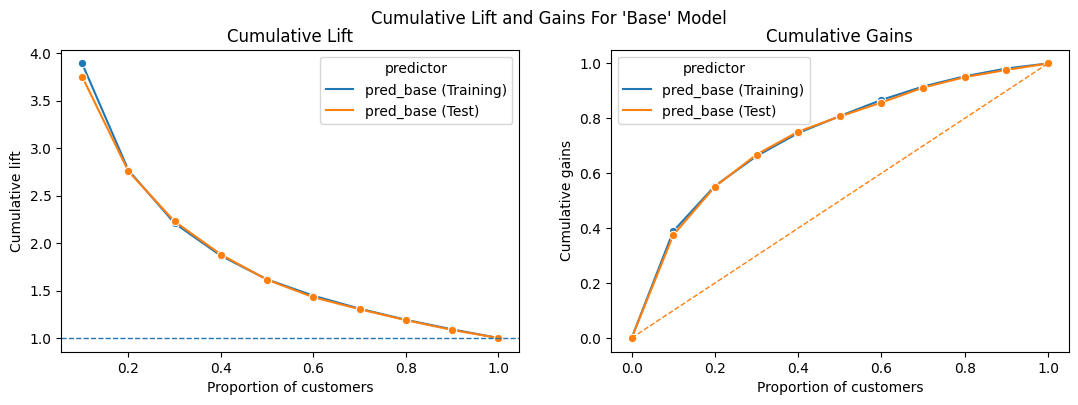

In [16]:
plots('pred_base', lr_base_mod, "Base")

From the base model, which has all the variables, except `id`, `sex`, `zip` and `training`, the summary is above. With the exception of `bizflag` and `sincepurch`, all the variables are significant predictors for `res1_yes`. The VIF values also look to be in range for this base model. In the next model, we will remove these two variables to check if there is a visible change. There is also no visible overfitting for this model.

In [17]:
# definition to calculate the profit of wave 1 using the model
def model_prof(var):
    test_set = intuit75k[intuit75k["training"] == 0]
    #display(test_set.head())
    prof = rsm.profit(pred=test_set[var], rvar=test_set["res1_yes"], lev=1, cost=1.41, margin=60,)
    return prof

In [18]:
base_profit = model_prof("pred_base")

#### Regression Model 2

In [19]:
# model 2 with 
lr_nobizpurch = smf.glm(
    formula="res1_yes ~ zip_bins + numords + dollars + last + version1 + owntaxprod + upgraded",
    family=Binomial(link=logit()),
    data=int_std.query("training == 1"),
)
lr_nobizpurch_mod = lr_nobizpurch.fit()

In [20]:
logit_disp(lr_nobizpurch, lr_nobizpurch_mod)


Pseudo R-squared (McFadden): 0.114
Pseudo R-squared (McFadden adjusted): 0.111
Log-likelihood: -8900.468, AIC: 17852.936, BIC: 18083.519
Chi-squared: 51336.309 df(25), p.value < 0.001 
Nr obs: 52,500



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               res1_yes   No. Observations:                52500
Model:                            GLM   Df Residuals:                    52474
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8900.5
Date:                Thu, 11 Feb 2021   Deviance:                       17801.
Time:                        10:32:26   Pearson chi2:                 5.13e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.8238      0.055    -33.013      0.000      -1.932      -1.716
zip_bins[T.2]      -1.9102      0.110    -17.300      0.000      -2.127      -1.694
zip_bins[T.3]      -2.1407      0.121    -17.709      0.000      -2.378      -1.904
zip_bins[T.4]      -1.9955      0.112    -17.806      0.000      -2.215      -1.776
zip_bins[T.5]      -2.1517      0.120    -17.894      0.000      -2.387      -1.916
zip_bins[T.6]      -2.0673      0.115    -18.042      0.000      -2.292      -1.843
zip_bins[T.7]      -2.1100      0.117    -17.974      0.000      -2.340      -1.880
zip_bins[T.8]      -2.0348      0.114    -17.848      0.000      -2.258      -1.811
zip_bins[T.9]      -2.0862      0.117    -17.859      0.000      -2.315      -1.857
zip_bins[T.10]     -2.1092      0.118    -17.917      0.000      -2.340      -1.879
zip_bins[T.11]     -2.0525      0.116    -17.642      0.000      -2.281      -1.825
zip_bins[T.12]     -1.7625      0.104    -16.869      0.000      -1.967      -1.558
zip_bins[T.13]     -2.1771      0.121    -17.942      0.000      -2.415      -1.939
zip_bins[T.14]     -2.0308      0.115    -17.722      0.000      -2.255      -1.806
zip_bins[T.15]     -2.1351      0.119    -17.895      0.000      -2.369      -1.901
zip_bins[T.16]     -2.0414      0.114    -17.894      0.000      -2.265      -1.818
zip_bins[T.17]     -2.0380      0.114    -17.852      0.000      -2.262      -1.814
zip_bins[T.18]     -1.6974      0.101    -16.739      0.000      -1.896      -1.499
zip_bins[T.19]     -1.9471      0.111    -17.504      0.000      -2.165      -1.729
zip_bins[T.20]     -2.0840      0.116    -17.977      0.000      -2.311      -1.857
version1[T.1]       0.7802      0.053     14.810      0.000       0.677       0.883
owntaxprod[T.1]     0.3055      0.103      2.971      0.003       0.104       0.507
upgraded[T.1]       0.9939      0.051     19.598      0.000       0.895       1.093
numords             0.5699      0.047     12.041      0.000       0.477       0.663
dollars             0.1776      0.044      4.022      0.000       0.091       0.264
last               -0.8355      0.046    -18.073      0.000      -0.926      -0.745
===================================================================================
"""

,variable,vif,Rsq
0,zip_bins[T.7],1.901,0.474
1,zip_bins[T.18],1.900,0.474
2,zip_bins[T.8],1.899,0.473
3,zip_bins[T.6],1.895,0.472
4,zip_bins[T.16],1.893,0.472
5,zip_bins[T.13],1.888,0.470
6,zip_bins[T.5],1.887,0.470
7,zip_bins[T.12],1.887,0.470
8,zip_bins[T.10],1.886,0.470
9,zip_bins[T.2],1.883,0.469


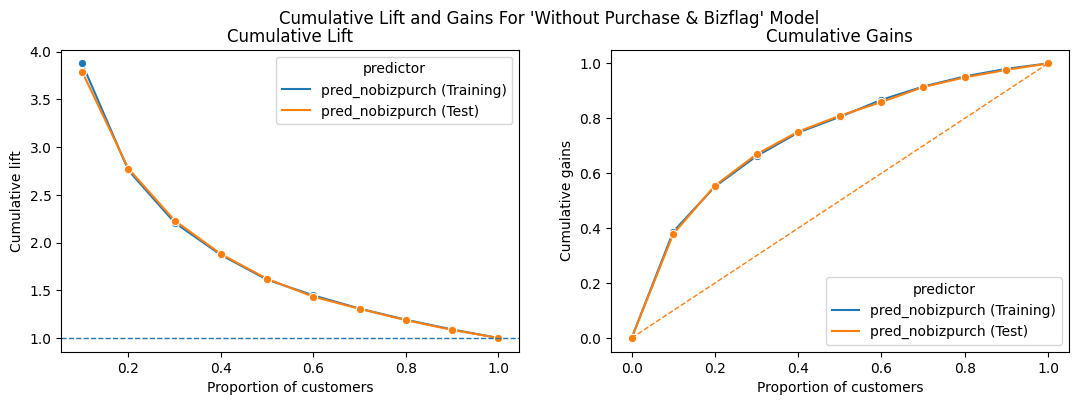

In [21]:
plots('pred_nobizpurch', lr_nobizpurch_mod, "Without Purchase & Bizflag")

In [22]:
nobizpurch_profit = model_prof("pred_nobizpurch")

While the model above is now made up of variables that are all significant, the profit slightly decreases, thus not making this the best model.

#### Regression Model 3

In [23]:
lr_addzip = smf.glm(
    formula="res1_yes ~  z_81 + z_84 + numords + dollars + last + version1 + owntaxprod + upgraded",
    family=Binomial(link=logit()),
    data=int_std.query("training == 1"),
)
lr_addzip_mod = lr_addzip.fit()

In [24]:
logit_disp(lr_addzip, lr_addzip_mod)


Pseudo R-squared (McFadden): 0.146
Pseudo R-squared (McFadden adjusted): 0.145
Log-likelihood: -8577.001, AIC: 17172.002, BIC: 17251.82
Chi-squared: 52226.157 df(8), p.value < 0.001 
Nr obs: 52,500



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               res1_yes   No. Observations:                52500
Model:                            GLM   Df Residuals:                    52491
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8577.0
Date:                Thu, 11 Feb 2021   Deviance:                       17154.
Time:                        10:32:29   Pearson chi2:                 5.22e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.8957      0.039    -99.941      0.000      -3.972      -3.819
z_81[T.1]           3.0871      0.068     45.212      0.000       2.953       3.221
z_84[T.1]           2.7625      0.199     13.867      0.000       2.372       3.153
version1[T.1]       0.8156      0.054     15.091      0.000       0.710       0.922
owntaxprod[T.1]     0.3248      0.104      3.111      0.002       0.120       0.529
upgraded[T.1]       1.0478      0.052     20.146      0.000       0.946       1.150
numords             0.6133      0.048     12.707      0.000       0.519       0.708
dollars             0.1840      0.045      4.132      0.000       0.097       0.271
last               -0.8673      0.047    -18.321      0.000      -0.960      -0.775
===================================================================================
"""

,variable,vif,Rsq
0,numords,1.558,0.358
1,dollars,1.527,0.345
2,upgraded[T.1],1.082,0.075
3,version1[T.1],1.081,0.075
4,owntaxprod[T.1],1.027,0.026
5,last,1.017,0.017
6,z_84[T.1],1.000,0.000
7,z_81[T.1],1.000,0.000


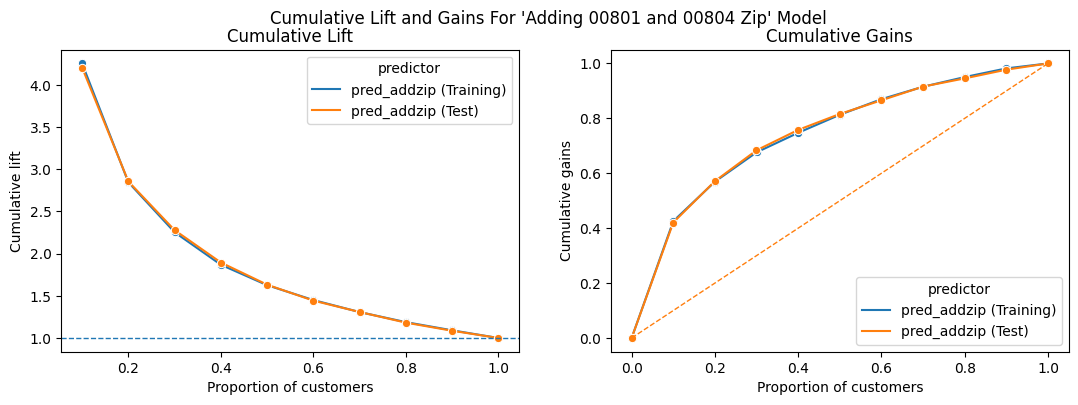

In [25]:
plots('pred_addzip', lr_addzip_mod, "Adding 00801 and 00804 Zip")

In [26]:
addzip_profit = model_prof("pred_addzip")

#### Regression Model 4

In [27]:
lr_v1biz = smf.glm(
    formula="res1_yes ~ zip_bins + bizflag + numords + dollars + last + upgraded + owntaxprod + bizflag:version1",
    family=Binomial(link=logit()),
    data=int_std.query("training == 1"),
)
lr_v1biz_mod = lr_v1biz.fit()

In [28]:
logit_disp(lr_v1biz, lr_v1biz_mod)


Pseudo R-squared (McFadden): 0.114
Pseudo R-squared (McFadden adjusted): 0.111
Log-likelihood: -8900.092, AIC: 17856.184, BIC: 18104.504
Chi-squared: 51311.911 df(27), p.value < 0.001 
Nr obs: 52,500



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               res1_yes   No. Observations:                52500
Model:                            GLM   Df Residuals:                    52472
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8900.1
Date:                Thu, 11 Feb 2021   Deviance:                       17800.
Time:                        10:32:30   Pearson chi2:                 5.13e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.8366      0.057    -32.101      0.000      -1.949      -1.724
zip_bins[T.2]               -1.9097      0.110    -17.294      0.000      -2.126      -1.693
zip_bins[T.3]               -2.1406      0.121    -17.708      0.000      -2.378      -1.904
zip_bins[T.4]               -1.9959      0.112    -17.809      0.000      -2.216      -1.776
zip_bins[T.5]               -2.1513      0.120    -17.891      0.000      -2.387      -1.916
zip_bins[T.6]               -2.0671      0.115    -18.040      0.000      -2.292      -1.843
zip_bins[T.7]               -2.1088      0.117    -17.962      0.000      -2.339      -1.879
zip_bins[T.8]               -2.0344      0.114    -17.844      0.000      -2.258      -1.811
zip_bins[T.9]               -2.0857      0.117    -17.854      0.000      -2.315      -1.857
zip_bins[T.10]              -2.1087      0.118    -17.911      0.000      -2.339      -1.878
zip_bins[T.11]              -2.0519      0.116    -17.636      0.000      -2.280      -1.824
zip_bins[T.12]              -1.7621      0.104    -16.864      0.000      -1.967      -1.557
zip_bins[T.13]              -2.1766      0.121    -17.937      0.000      -2.414      -1.939
zip_bins[T.14]              -2.0303      0.115    -17.716      0.000      -2.255      -1.806
zip_bins[T.15]              -2.1346      0.119    -17.891      0.000      -2.368      -1.901
zip_bins[T.16]              -2.0410      0.114    -17.890      0.000      -2.265      -1.817
zip_bins[T.17]              -2.0372      0.114    -17.843      0.000      -2.261      -1.813
zip_bins[T.18]              -1.6972      0.101    -16.737      0.000      -1.896      -1.498
zip_bins[T.19]              -1.9467      0.111    -17.499      0.000      -2.165      -1.729
zip_bins[T.20]              -2.0834      0.116    -17.971      0.000      -2.311      -1.856
bizflag[T.1]                 0.0500      0.057      0.870      0.385      -0.063       0.163
upgraded[T.1]                0.9939      0.051     19.595      0.000       0.894       1.093
owntaxprod[T.1]              0.3043      0.103      2.958      0.003       0.103       0.506
bizflag[0]:version1[T.1]     0.7931      0.059     13.415      0.000       0.677       0.909
bizflag[1]:version1[T.1]     0.7410      0.099      7.507      0.000       0.548       0.934
numords                      0.5700      0.047     12.044      0.000       0.477       0.663
dollars                      0.1772      0.044      4.014      0.000       0.091       0.264
last                        -0.8354      0.046    -18.072      0.000      -0.926      -0.745
============================================================================================
"""

,variable,vif,Rsq
0,zip_bins[T.7],1.901,0.474
1,zip_bins[T.18],1.900,0.474
2,zip_bins[T.8],1.899,0.474
3,zip_bins[T.6],1.895,0.472
4,zip_bins[T.16],1.893,0.472
5,zip_bins[T.13],1.888,0.470
6,zip_bins[T.5],1.888,0.470
7,zip_bins[T.12],1.887,0.470
8,zip_bins[T.10],1.886,0.470
9,zip_bins[T.2],1.884,0.469


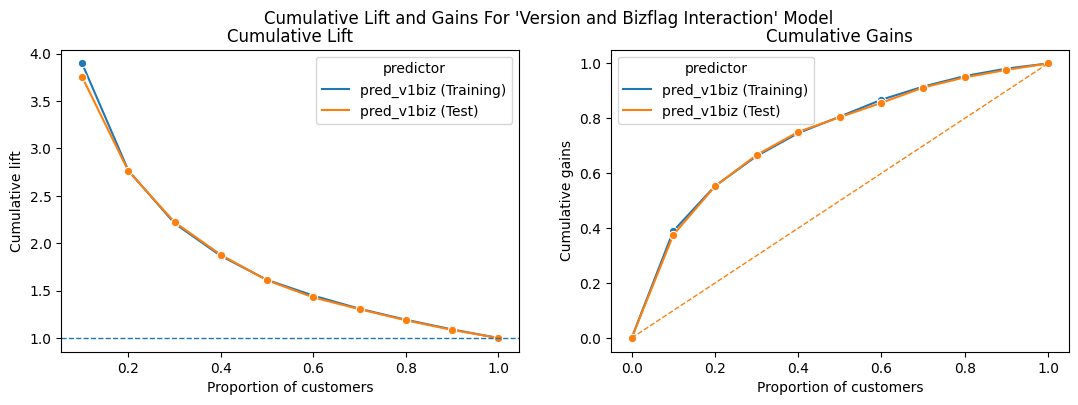

In [29]:
plots('pred_v1biz', lr_v1biz_mod, "Version and Bizflag Interaction")

In [30]:
v1biz_profit = model_prof("pred_v1biz")

#### Regression Model 5

In [31]:
lr_newbin = smf.glm(
    formula="res1_yes ~ new_bins + numords + dollars + last + version1 + owntaxprod:upgraded",
    family=Binomial(link=logit()),
    data=int_std.query("training == 1"),
)
lr_newbin_mod = lr_newbin.fit()

In [32]:
logit_disp(lr_newbin, lr_newbin_mod)


Pseudo R-squared (McFadden): 0.094
Pseudo R-squared (McFadden adjusted): 0.092
Log-likelihood: -9104.097, AIC: 18242.193, BIC: 18392.959
Chi-squared: 51700.698 df(16), p.value < 0.001 
Nr obs: 52,500



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               res1_yes   No. Observations:                52500
Model:                            GLM   Df Residuals:                    52483
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9104.1
Date:                Thu, 11 Feb 2021   Deviance:                       18208.
Time:                        10:32:33   Pearson chi2:                 5.17e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.4696      0.050    -49.222      0.000      -2.568      -2.371
new_bins[T.2]                  -1.4145      0.085    -16.550      0.000      -1.582      -1.247
new_bins[T.3]                  -1.4591      0.086    -16.919      0.000      -1.628      -1.290
new_bins[T.4]                  -1.4230      0.085    -16.715      0.000      -1.590      -1.256
new_bins[T.5]                  -1.4493      0.086    -16.804      0.000      -1.618      -1.280
new_bins[T.6]                  -1.2491      0.081    -15.397      0.000      -1.408      -1.090
new_bins[T.7]                  -1.4526      0.087    -16.778      0.000      -1.622      -1.283
new_bins[T.8]                  -1.4385      0.086    -16.771      0.000      -1.607      -1.270
new_bins[T.9]                  -1.2067      0.079    -15.223      0.000      -1.362      -1.051
new_bins[T.10]                 -1.3655      0.084    -16.319      0.000      -1.530      -1.202
version1[T.1]                   0.7845      0.052     14.970      0.000       0.682       0.887
upgraded[T.1]                   0.9972      0.052     19.285      0.000       0.896       1.099
owntaxprod[T.1]:upgraded[0]     0.4386      0.151      2.909      0.004       0.143       0.734
owntaxprod[T.1]:upgraded[1]     0.2281      0.136      1.682      0.092      -0.038       0.494
numords                         0.5597      0.047     11.971      0.000       0.468       0.651
dollars                         0.1749      0.044      4.014      0.000       0.089       0.260
last                           -0.8207      0.046    -17.962      0.000      -0.910      -0.731
===============================================================================================
"""

,variable,vif,Rsq
0,new_bins[T.4],1.807,0.446
1,new_bins[T.3],1.799,0.444
2,new_bins[T.9],1.798,0.444
3,new_bins[T.8],1.796,0.443
4,new_bins[T.7],1.794,0.442
5,new_bins[T.6],1.791,0.442
6,new_bins[T.10],1.791,0.442
7,new_bins[T.5],1.789,0.441
8,new_bins[T.2],1.788,0.441
9,numords,1.558,0.358


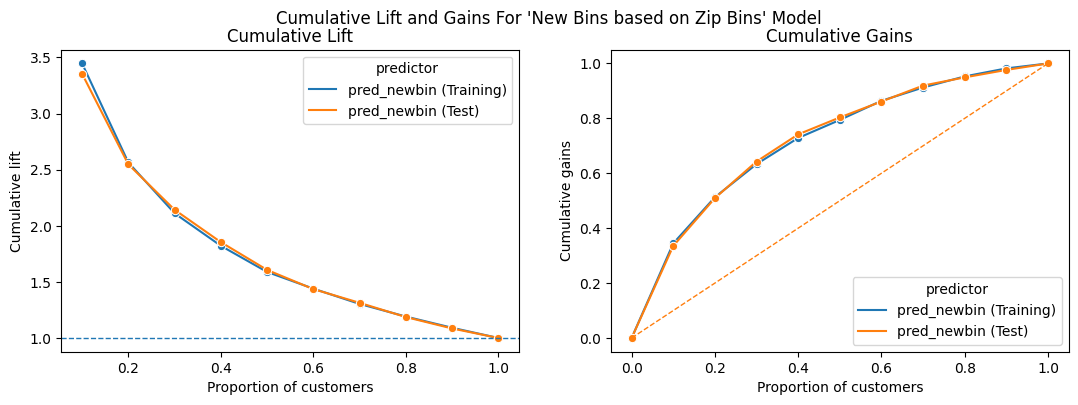

In [33]:
plots('pred_newbin', lr_newbin_mod, "New Bins based on Zip Bins")

In [34]:
newbin_profit = model_prof("pred_newbin")

In [35]:
# table of the profits from the different methods
profits = [base_profit, nobizpurch_profit, addzip_profit, v1biz_profit, newbin_profit]
prof_ind = ['base_profit', 'nobizpurch_profit', 'addzip_profit', 'v1biz_profit', 'newbin_profit']

profits = pd.DataFrame(profits, index = prof_ind)
profits.columns = ['Profits (USD)']
profits = profits.sort_values('Profits (USD)', ascending = False)
profits

,Profits (USD)
newbin_profit,38782.65
base_profit,38561.49
nobizpurch_profit,38557.26
addzip_profit,38528.16
v1biz_profit,38491.62


## Neural Network Model

In [36]:
pq = pd.get_dummies(
    int_std[
        [
            "numords",
            "dollars",
            "last",
            "owntaxprod",
            "upgraded",
            "version1",
            "z_81",
            "z_84",
        ]
    ],
    drop_first=True,
)

p = pd.get_dummies(
    int_std[int_std["training"] == 1][
        [
            "numords",
            "dollars",
            "last",
            "owntaxprod",
            "upgraded",
            "version1",
            "z_81",
            "z_84",
        ]
    ],
    drop_first=True,
)
q = pd.get_dummies(
    int_std[int_std["training"] == 0][
        [
            "numords",
            "dollars",
            "last",
            "owntaxprod",
            "upgraded",
            "version1",
            "z_81",
            "z_84",
        ]
    ],
    drop_first=True,
)


A_train = p.values
A_test = q.values

b_train = int_std[int_std["training"] == 1].res1_yes.values
b_test = int_std[int_std["training"] == 0].res1_yes.values

A_train_df = pd.DataFrame(p)
b_train_df = int_std.loc[int_std.training == 1, "res1_yes"]

In [37]:
# nn & importance function 
def nn(X, y, hlsizes=(1,), max_iter=1000):
    return MLPClassifier(
        activation="relu",
        solver="adam",
        hidden_layer_sizes=hlsizes,
        random_state=1234,
        max_iter=max_iter,
    ).fit(X, y)


def importance(clf, X, y):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = X.columns
    fig = sns.barplot(x="variable", y="value", color="slateblue", data=pd.melt(data))
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)

In [38]:
# initial nn model building
clf_2 = nn(A_train, b_train, (2,))
pred_2 = clf_2.predict_proba(pq)[:, 1]

pred_2_tr = clf_2.predict_proba(A_train)
fpr, tpr, thresholds = metrics.roc_curve(b_train, pred_2_tr[:, 1])

pred_2_test = clf_2.predict_proba(A_test)
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(b_test, pred_2_test[:, 1])

print(f"AUC training data for intial model: {metrics.auc(fpr, tpr)}")
print(f"AUC testing data for intial model: {metrics.auc(fpr_t, tpr_t)}")

AUC training data for intial model: 0.7605818425389486
AUC testing data for intial model: 0.7609749775972442


In [39]:
# calculating the profit
testing_set = intuit75k[intuit75k["training"] == 0]
nn_prof = rsm.profit(pred = pd.Series(pred_2), rvar = testing_set['res1_yes'], lev = 1, cost = 1.41, margin = 60)
nn_prof

37631.28

In [40]:
# GridSearch validation
hls = [(1,), (2,)]

param_grid = {"hidden_layer_sizes": hls}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV(
    clf_2, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
)
clf_cv.fit(A_train, b_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(hidden_layer_sizes=(2,), max_iter=1000,
                                     random_state=1234),
             n_jobs=4, param_grid={'hidden_layer_sizes': [(1,), (2,)]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [41]:
print(f"Best params: {clf_cv.best_params_}")
print(f"Best score: {clf_cv.best_score_}")

Best params: {'hidden_layer_sizes': (1,)}
Best score: 0.7636023655723125


In [42]:
# prediction on training & testing sets
pred_cv_tr = clf_cv.predict_proba(A_train)
fpr, tpr, thresholds = metrics.roc_curve(b_train, pred_cv_tr[:, 1])

pred_t = clf_cv.predict_proba(A_test)
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(b_test, pred_t[:, 1])

print(f"AUC training data for tuned optimal model: {metrics.auc(fpr, tpr)}")
print(f"AUC testing data for tuned optimal model: {metrics.auc(fpr_t, tpr_t)}")

AUC training data for tuned optimal model: 0.7639939318360012
AUC testing data for tuned optimal model: 0.7638286410457978


Based on this tuned model, there is no overfitting in this neural network model.

# Comparison Of Models

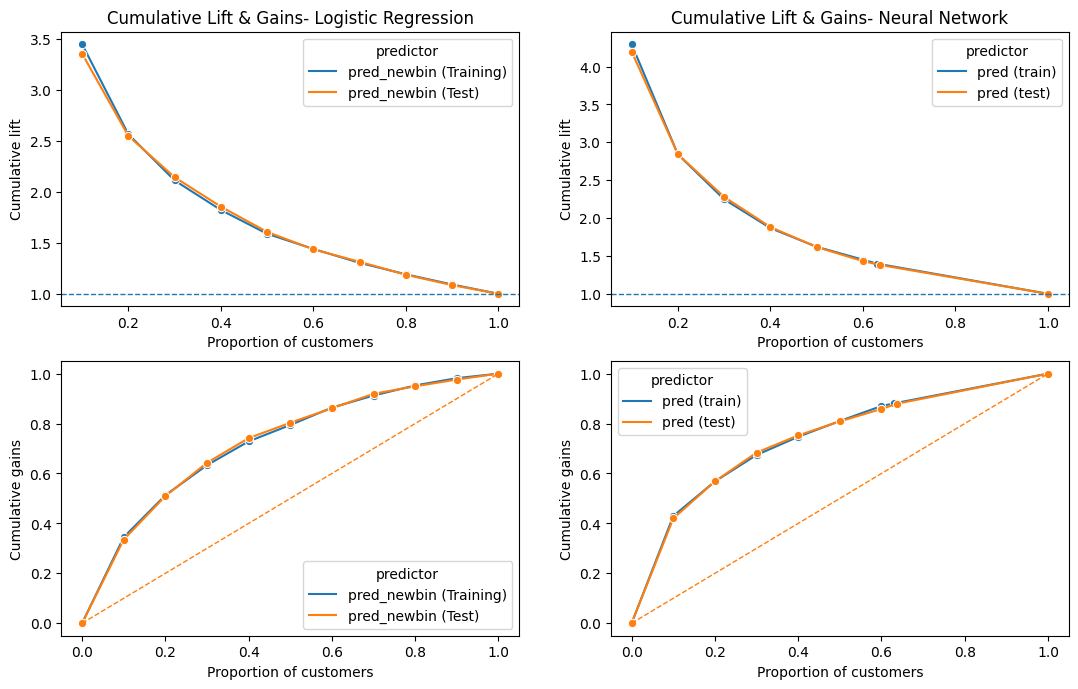

In [43]:
# comparative lifts and gains charts
w = 13
h = 8
d = 100
fig = plt.figure(figsize=(w, h), dpi=d)

fig1 = fig.add_subplot(221)
fig1.set_title("Cumulative Lift & Gains- Logistic Regression")
fig1 = rsm.lift_plot({"Training": intuit75k.query("training == 1"), "Test": intuit75k.query("training == 0"),},
                      rvar="res1_yes", pred='pred_newbin', lev=1, qnt=10,)

pred_train = pd.DataFrame().assign(
    actual=b_train, pred=clf_2.predict_proba(A_train)[:, 1]
)
pred_test = pd.DataFrame().assign(actual=b_test, pred=clf_2.predict_proba(A_test)[:, 1])
dct = {"train": pred_train, "test": pred_test}
fig2 = fig.add_subplot(222)
fig2 = rsm.lift_plot(dct, "actual", 1, "pred")
fig2.set_title("Cumulative Lift & Gains- Neural Network")

fig3 = fig.add_subplot(223)
fig3 = rsm.gains_plot({"Training": intuit75k.query("training == 1"), "Test": intuit75k.query("training == 0"),},
                      rvar="res1_yes", pred='pred_newbin', lev=1, qnt=10,)

pred_train = pd.DataFrame().assign(
    actual=b_train, pred=clf_2.predict_proba(A_train)[:, 1]
)
pred_test = pd.DataFrame().assign(actual=b_test, pred=clf_2.predict_proba(A_test)[:, 1])
dct = {"train": pred_train, "test": pred_test}
fig4 = fig.add_subplot(224)
fig4 = rsm.gains_plot(dct, "actual", 1, "pred")
#fig2.set_title("Cumulative Gains- Neural Network")

The cumulative lift & gains plots above are for the neural network model and the most profitable logistic regression model. 

While overfitting is not observed, it is also important to note the variability in results for neural networks. In addition to the sensitivity of using a random state within the model, the OS affects the results of the neural net. Because of this over-sensitivity to factors that cannot necessarily be controlled, we have opted to use the logistic regression model. And we will be using the most profitable model, with respect to wave 1 results. 

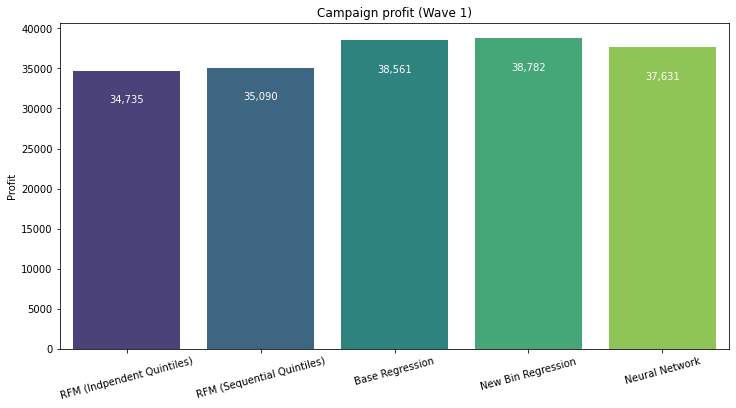

In [44]:
what_now = pd.DataFrame(
    {
        "name": [
            "RFM (Indpendent Quintiles)",
            "RFM (Sequential Quintiles)",
            "Base Regression",
            "New Bin Regression",
            "Neural Network"
        ],
        "Profit": [
            profit_sq_se, 
            profit_iq_se,
            base_profit,
            newbin_profit,
            nn_prof,
        ],
    }
)

# plot
plt.figure(figsize=(12, 6))
fig = sns.barplot(x="name", y="Profit", palette="viridis", data=what_now)
plt.xticks(rotation=15)
fig.set(xlabel="", ylabel="Profit", title="Campaign profit (Wave 1)")

# labels of values
for index, row in what_now.iterrows():
    fig.text(
        row.name, row.Profit - 4000, f"{int(row.Profit):,}", ha="center", color="white"
    )

### Profits

In [45]:
# calculations below are consolidated here so it is easier to run and read
intuit75k["logit_pred"] = lr_newbin_mod.predict(int_std)
# adjust for wave2
intuit75k["logit_pred_wave2"] = intuit75k["logit_pred"] * 0.5
intuit75k["mailto_wave2"] = intuit75k["logit_pred_wave2"] > breakeven

mail_list_x = intuit75k[intuit75k["training"] == 0][
    intuit75k[intuit75k["training"] == 0]["mailto_wave2"] == True
]
mail_list_x = mail_list_x[mail_list_x["res1"] == "No"]
mail_num = mail_list_x.shape[0]
# profit calc
check = intuit75k[intuit75k["training"] == 1][
    intuit75k[intuit75k["training"] == 1]["mailto_wave2"] == True
]
x = check.shape[0]
y = check[check["res1"] == "Yes"].shape[0]
buyrate = y / x

new_revenue_x = mail_num * 60 * buyrate
new_mail_cost_x = mail_num * 1.41
new_profit_x = new_revenue_x - new_mail_cost_x
new_rome_x = new_profit_x / new_mail_cost_x
print(
    f"""Logistic Regression Model: The Profit is ${int(new_profit_x):,} and the the return on investment is {round(float(new_rome_x)*100,2):,}% """
)

Logistic Regression Model: The Profit is $29,635 and the the return on investment is 309.5% 


To now scale up the profits to the full set of businesses to target in wave 2, we will use the values calculated up until this point. We will divide the profit generated for the test set above by the number of business we targeted in the test set. This ratio will then be multiplied by the number of businesses that have were mailed, but did not respond to the wave 1 campaign.

In [46]:
new_profit_x / 21397 * (801821 - 38487)

1057238.882495583

In [47]:
# generate a csv file to submit
intuit75k["mailto_wave2"] = np.where(
    intuit75k["res1"] == "Yes", False, intuit75k["logit_pred_wave2"] > breakeven
)
submission = intuit75k[intuit75k["training"] == 0]
submission = submission[["id", "mailto_wave2"]]

submission.to_csv("Haritha_Julian_Praveen_Will_Team17.csv", index=False)

In [49]:
submission[['mailto_wave2']].value_counts()

mailto_wave2
False           15709
True             6791
dtype: int64